# **1. Import libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [ ]:
plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")
pd.set_option("display.max_columns", None)

# **2. Load dataset**

In [ ]:
df = pd.read_csv("netflix_titles.csv")

# **3. Data overview**

In [ ]:
print("Shape of dataset:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())
print("\nSample Data:\n", df.head())

Shape of dataset: (8807, 12)

Data Types:
 show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object

Missing values:
 show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

Sample Data:
   show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN 

# **4. Data cleaning**

In [ ]:
# strip whitespace from column names if any
df.columns = df.columns.str.strip()

In [ ]:
# handle missing 'date_added' by converting to datetime and coerce errors to NaT
df['date_added'] = pd.to_datetime(df['date_added'].str.strip(), format='%B %d, %Y', errors='coerce')

In [ ]:
# drop rows with invalid or missing date_added for temporal analysis
df = df.dropna(subset=['date_added'])

In [ ]:
# fill NaN in 'country' with 'Unknown'
df['country'] = df['country'].fillna('Unknown')

In [ ]:
# fill missing 'director', 'cast', 'rating', 'duration' with appropriate placeholders
df['director'] = df['director'].fillna('Unknown')
df['cast'] = df['cast'].fillna('Unknown')
df['rating'] = df['rating'].fillna('Not Rated')
df['duration'] = df['duration'].fillna('Unknown')

# **5. Feature engineering**

In [ ]:
# extract year and month from date_added
df['year_added'] = df['date_added'].dt.year.astype(int)
df['month_added'] = df['date_added'].dt.month_name()

In [ ]:
# اandle multi-country and multi-genre by exploding for accurate analysis
df_exploded_countries = df.assign(country=df['country'].str.split(',')).explode('country')
df_exploded_countries['country'] = df_exploded_countries['country'].str.strip()
df_exploded_countries = df_exploded_countries[df_exploded_countries['country'] != 'Unknown']

df_exploded_genres = df.assign(listed_in=df['listed_in'].str.split(',')).explode('listed_in')
df_exploded_genres['listed_in'] = df_exploded_genres['listed_in'].str.strip()

In [ ]:
# duration processing: extract numeric value and unit
df['duration_int'] = df['duration'].str.extract(r'(\d+)').astype(float)
df['duration_unit'] = df['duration'].str.extract(r'([a-zA-Z]+)')

In [ ]:
# standardize duration_unit for TV Shows ('Season' or 'Seasons' -> 'Seasons')
df.loc[df['type'] == 'TV Show', 'duration_unit'] = 'Seasons'
df.loc[df['type'] == 'Movie', 'duration_unit'] = 'min'

# **6. Exploratory data analysis**

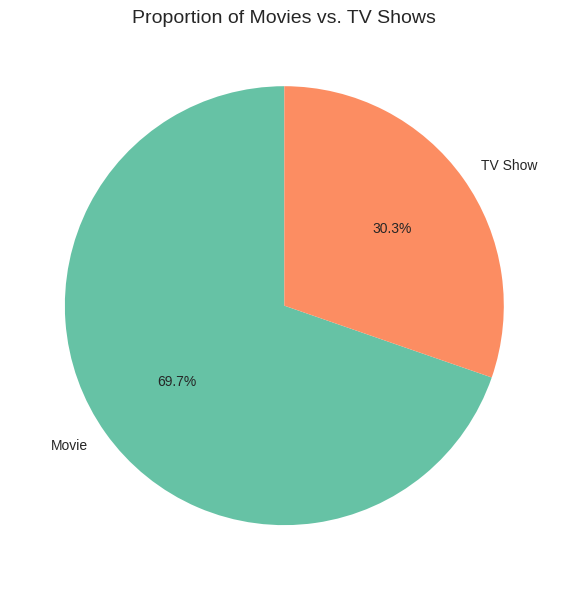

In [ ]:
# content distribution by type
type_counts = df['type'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', colors=sns.color_palette("Set2"), startangle=90)
plt.title("Proportion of Movies vs. TV Shows", fontsize=14)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

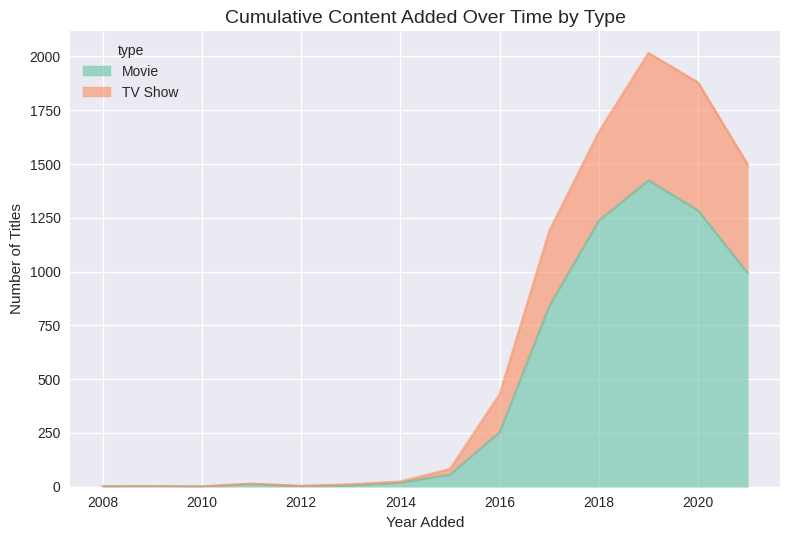

In [ ]:
# content added over time by year and type
content_per_year = df.groupby(['year_added', 'type']).size().unstack().fillna(0)
plt.figure(figsize=(10, 6))
content_per_year.plot(kind='area', stacked=True, color=sns.color_palette("Set2"), alpha=0.6)
plt.title("Cumulative Content Added Over Time by Type", fontsize=14)
plt.xlabel("Year Added")
plt.ylabel("Number of Titles")
plt.grid(True)
plt.tight_layout()
plt.show()

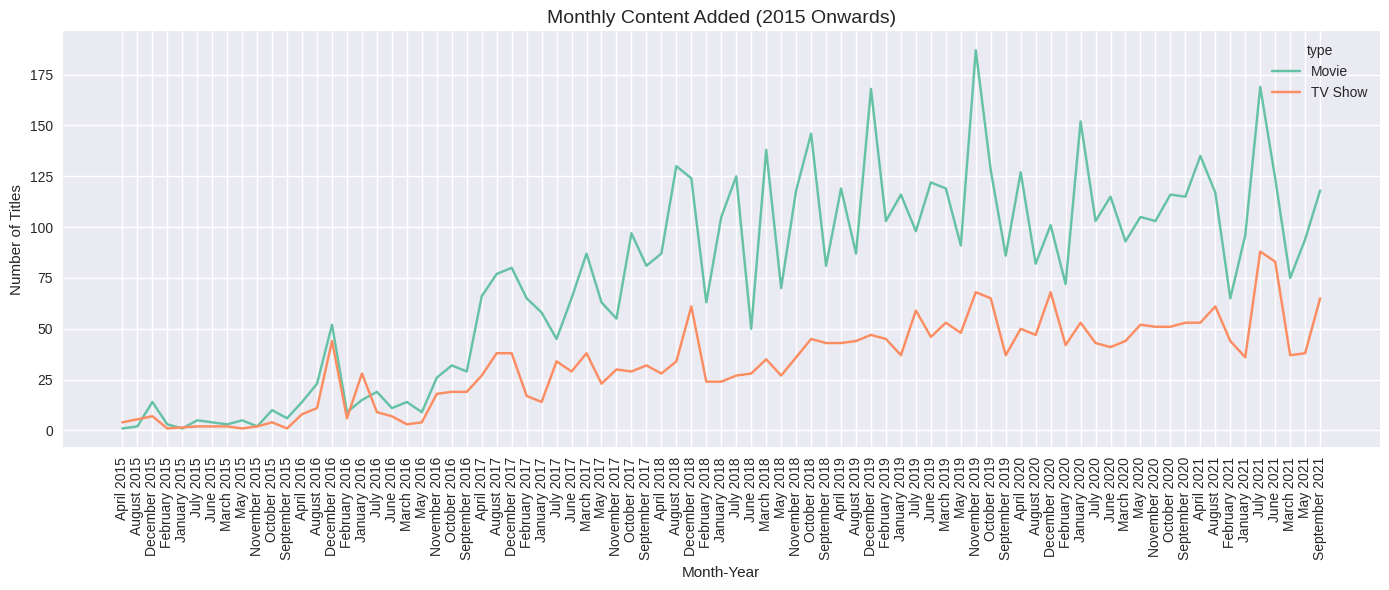

In [ ]:
# content added over time monthly trend for recent years
recent_years = df[df['year_added'] >= 2015]
monthly_content = recent_years.groupby(['year_added', 'month_added', 'type']).size().reset_index(name='count')
monthly_content['month_year'] = monthly_content['month_added'] + ' ' + monthly_content['year_added'].astype(str)
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_content, x='month_year', y='count', hue='type', palette='Set2')
plt.title("Monthly Content Added (2015 Onwards)", fontsize=14)
plt.xlabel("Month-Year")
plt.ylabel("Number of Titles")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1154778812.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_count.values, y=country_count.index, palette="coolwarm")


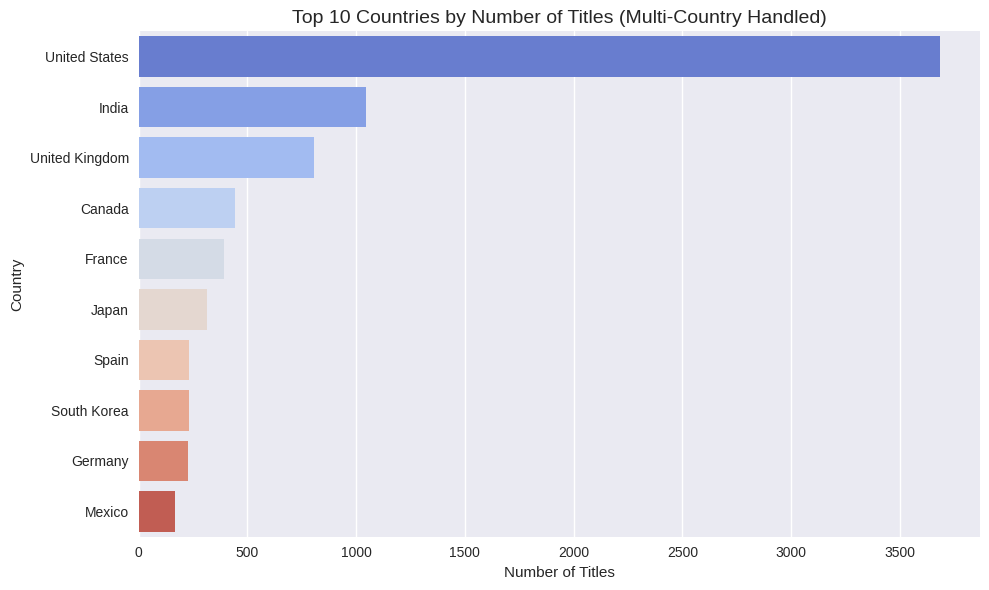

In [ ]:
# top countries by content
country_count = df_exploded_countries['country'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=country_count.values, y=country_count.index, palette="coolwarm")
plt.title("Top 10 Countries by Number of Titles (Multi-Country Handled)", fontsize=14)
plt.xlabel("Number of Titles")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

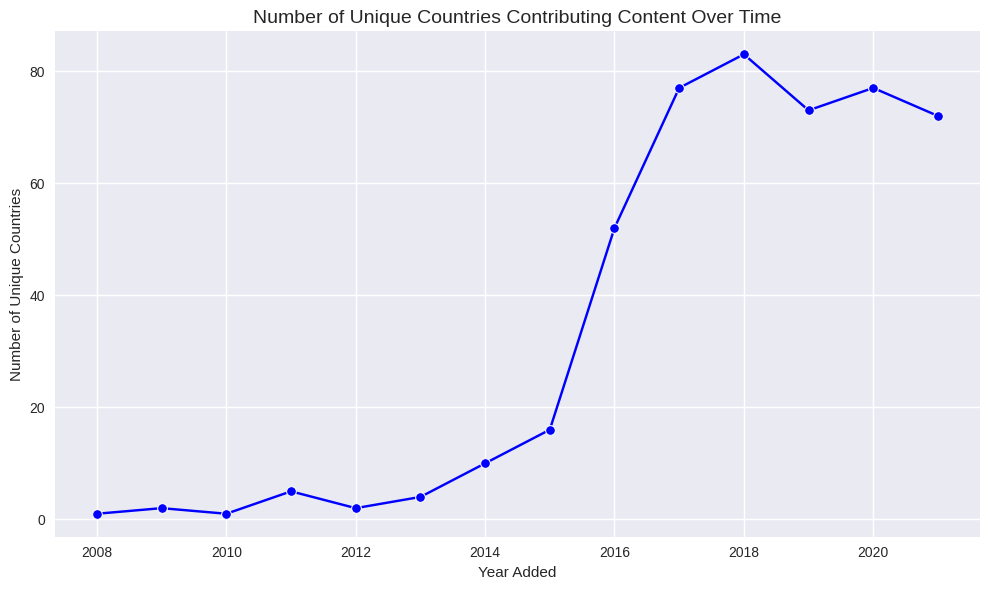

In [ ]:
#global expansion: unique countries over time
unique_countries_per_year = df_exploded_countries.groupby('year_added')['country'].nunique().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=unique_countries_per_year, x='year_added', y='country', marker="o", color='blue')
plt.title("Number of Unique Countries Contributing Content Over Time", fontsize=14)
plt.xlabel("Year Added")
plt.ylabel("Number of Unique Countries")
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2266013258.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=all_genres.values, y=all_genres.index, palette="viridis")


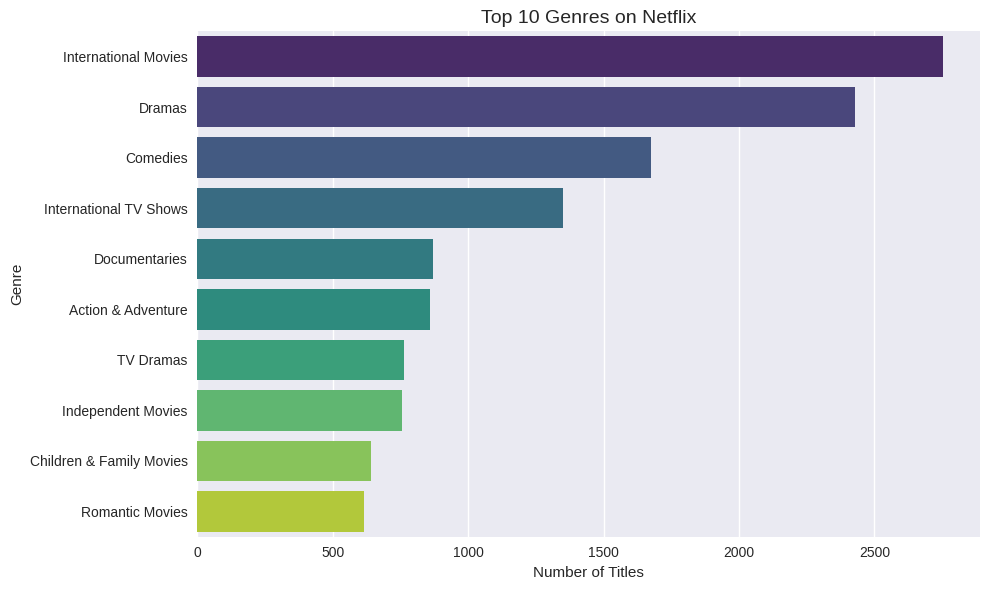

In [ ]:
# top genres overall
all_genres = df_exploded_genres['listed_in'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=all_genres.values, y=all_genres.index, palette="viridis")
plt.title("Top 10 Genres on Netflix", fontsize=14)
plt.xlabel("Number of Titles")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

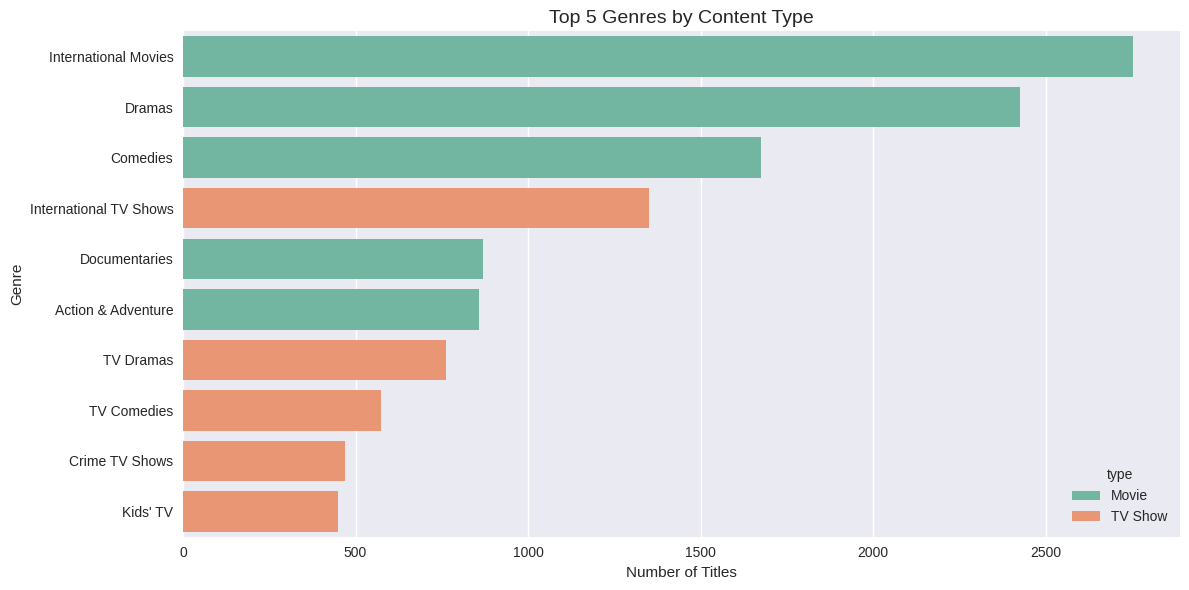

In [ ]:
# top genres by type
top_genres_by_type = df_exploded_genres.groupby(['type', 'listed_in']).size().reset_index(name='count')
top_genres_by_type = top_genres_by_type.sort_values('count', ascending=False).groupby('type').head(5)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_genres_by_type, x='count', y='listed_in', hue='type', palette='Set2')
plt.title("Top 5 Genres by Content Type", fontsize=14)
plt.xlabel("Number of Titles")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

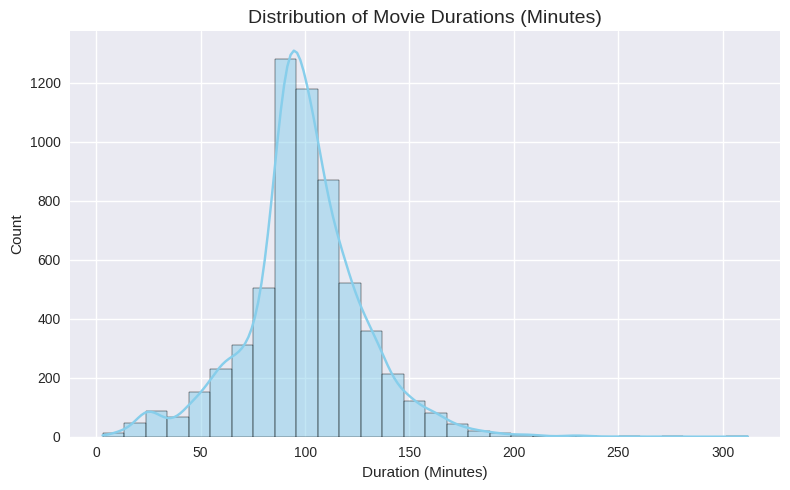

In [ ]:
# movie duration distribution
movies = df[df['type'] == 'Movie']
plt.figure(figsize=(8, 5))
sns.histplot(movies['duration_int'].dropna(), bins=30, kde=True, color='skyblue')
plt.title("Distribution of Movie Durations (Minutes)", fontsize=14)
plt.xlabel("Duration (Minutes)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

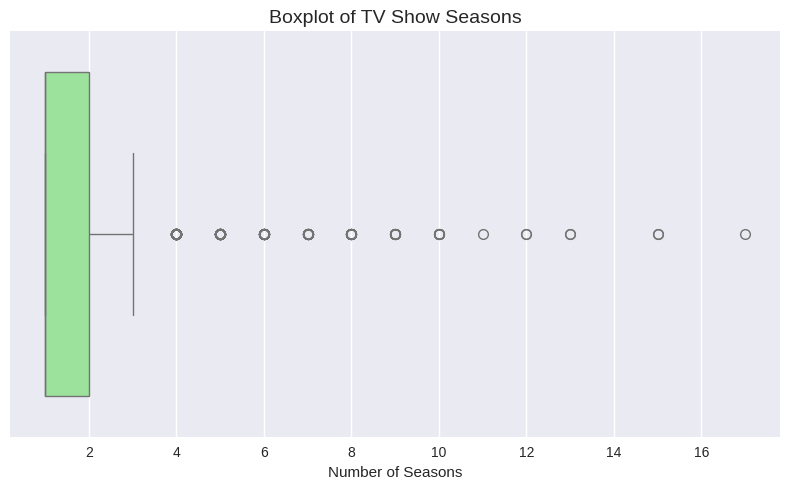

In [ ]:
# TV show seasons distribution
plt.figure(figsize=(8, 5))
sns.boxplot(x=df[df['type'] == 'TV Show']['duration_int'].dropna(), color='lightgreen')
plt.title("Boxplot of TV Show Seasons", fontsize=14)
plt.xlabel("Number of Seasons")
plt.tight_layout()
plt.show()

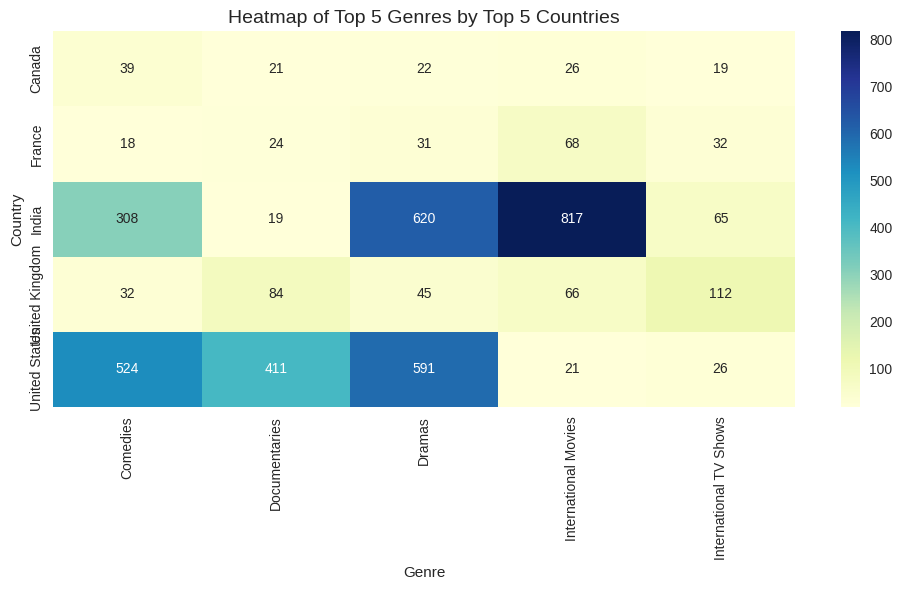

In [ ]:
# heatmap for genre vs. country analysis
top_5_countries = df_exploded_countries['country'].value_counts().head(5).index
top_5_genres = df_exploded_genres['listed_in'].value_counts().head(5).index
genre_country = df_exploded_genres[df_exploded_genres['listed_in'].isin(top_5_genres) &
                                   df_exploded_genres['country'].isin(top_5_countries)]
genre_country_pivot = genre_country.groupby(['country', 'listed_in']).size().unstack().fillna(0)
plt.figure(figsize=(10, 6))
sns.heatmap(genre_country_pivot, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title("Heatmap of Top 5 Genres by Top 5 Countries", fontsize=14)
plt.xlabel("Genre")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

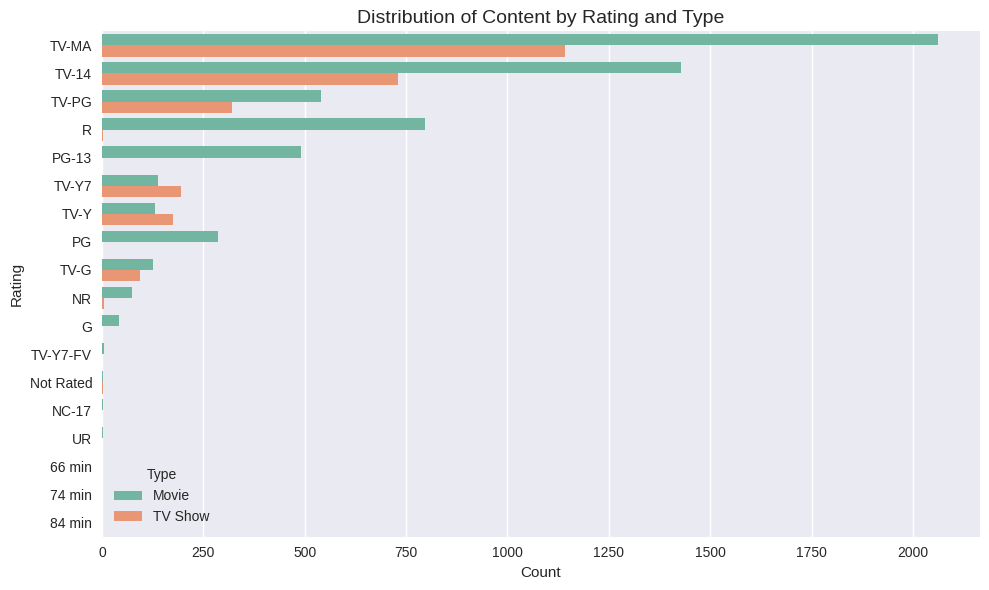

In [ ]:
# rating distribution analysis
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='rating', hue='type', palette='Set2', order=df['rating'].value_counts().index)
plt.title("Distribution of Content by Rating and Type", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Rating")
plt.legend(title="Type")
plt.tight_layout()
plt.show()

# **7. Insights summary**

In [ ]:
print(f"Total Titles: {df.shape[0]}")
print(f"Movies: {df[df['type'] == 'Movie'].shape[0]} ({round(100 * df['type'].value_counts(normalize=True)['Movie'], 2)}%)")
print(f"TV Shows: {df[df['type'] == 'TV Show'].shape[0]} ({round(100 * df['type'].value_counts(normalize=True)['TV Show'], 2)}%)")
print(f"Top Country: {country_count.index[0]} with {country_count.iloc[0]} titles.")
print(f"Most Common Genre: {all_genres.index[0]} with {all_genres.iloc[0]} titles.")
print(f"Average TV Show Seasons: {df[df['type'] == 'TV Show']['duration_int'].mean():.1f} | Median: {df[df['type'] == 'TV Show']['duration_int'].median():.1f} seasons.")
print("Genres like 'International Movies' and 'Dramas' dominate, reflecting Netflix's global and story-driven focus.")

Total Titles: 8797
Movies: 6131 (69.69%)
TV Shows: 2666 (30.31%)
Top Country: United States with 3684 titles.
Most Common Genre: International Movies with 2752 titles.
Average TV Show Seasons: 1.8 | Median: 1.0 seasons.
Genres like 'International Movies' and 'Dramas' dominate, reflecting Netflix's global and story-driven focus.
